# Intro

The goal of this is to first create and train a neural network on the AT&T Faces Dataset. This is a Siamese Network where the neural network will be trained to distinguish between pairs of images. It does this by optimizing a contrastive loss function, which is basically the Euclidean distance between the images. After training the network, we test it out first on the hold-out set, results of which are generally satisfactory. We then go on to test on other images, the results of which still need to be improved. All credit goes to: https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/blob/master/Siamese-networks-medium.ipynb

# Import

In [48]:
%matplotlib inline
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

We will need these libraries. You'll have to pip install PyTorch if you haven't already.

# Helpers

In [49]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor': 'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

We'll use these functions later when we want to visualise the images and plot the training results. Don't worry about the text argument, that's just to help us see the dissimilarity value later on.

# Load Data

In [50]:
training_dir = r"D:\Java1D\Java1DProject\orl_faces\training" # change this to your own directory
testing_dir = r"D:\Java1D\Java1DProject\orl_faces\testing" # change this to your own directory
batch_size = 64
num_epochs = 100

Download the AT&T data from: https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html . Separate out 3 folders to be in your testing set.

In [63]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        should_get_same_class = random.randint(0,1)
        if should_get_same_class: # apparently you can do if (1)
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                   break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break
                    
        img0 = Image.open(img0_tuple[0]) # we need to open since the images are in .pgm format. img_tuple[0] provides the path
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L") # this is to convert images to B&W
        img1 = img1.convert("L")
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img0_tuple[1]!= img1_tuple[1])],dtype=np.float32))
                    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    

Here, what we want to do is to have our dataset randomly generate (img1, img2, ground_truth_label). The pair of images are randomly picked, so they might or might not be the same class. If they are different class, ground_truth_label is 1, otherwise 0. We create the class for the SiameseNetworkDataset, which is a subclass of PyTorch Dataset. All Datasets have the _getitem_ method implemented which allows it to be passed into a DataLoader, which will load the samples into your model. Note that the imageFolderDataset is an ImageFolder(_path_) instance, which has the _imgs_ method, which returns a list of tuples (path, class index). Check it out here: https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py 

In [52]:
folder_dataset = torchvision.datasets.ImageFolder(root=training_dir)
print(len(folder_dataset))

370


There are 37 folders, each containing 10 pictures. So it's correct.

In [53]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                       transform=transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()]))

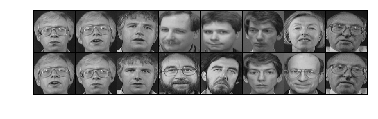

[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]


In [54]:
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)
example = next(dataiter)
concatenated = torch.cat((example[0], example[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example[2].numpy())

Zoom in to see the faces. You'll notice that when the faces are the same, the ground truth label is 0, and 1 when they are different, as expected.

# Defining the Network

In [75]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8)
            )
        
        self.fc = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500,5))
        
    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size()[0], -1) # flatten to (batch_size, whatever)
        output = self.fc(x)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2


In [76]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        euclidean_dist = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_dist,2) + 
                                        (label) * torch.pow(torch.clamp(self.margin - euclidean_dist,min=0.0),2))
        
        return loss_contrastive

# Training the Network

In [77]:
train_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size = batch_size)

In [78]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

Here we move the NN onto CUDA and create the instance of ContrastiveLoss called criterion. We also create the optimizer

Epoch Number 0 
 Current Loss 1.8366622924804688

Epoch Number 1 
 Current Loss 1.4580562114715576

Epoch Number 2 
 Current Loss 1.3089091777801514

Epoch Number 3 
 Current Loss 1.1800262928009033

Epoch Number 4 
 Current Loss 1.2358362674713135

Epoch Number 5 
 Current Loss 1.140883445739746

Epoch Number 6 
 Current Loss 1.1393592357635498

Epoch Number 7 
 Current Loss 1.1520731449127197

Epoch Number 8 
 Current Loss 1.167912244796753

Epoch Number 9 
 Current Loss 1.1356338262557983

Epoch Number 10 
 Current Loss 1.1757022142410278

Epoch Number 11 
 Current Loss 1.1599056720733643

Epoch Number 12 
 Current Loss 1.1226398944854736

Epoch Number 13 
 Current Loss 1.1186412572860718

Epoch Number 14 
 Current Loss 1.1985414028167725

Epoch Number 15 
 Current Loss 1.1142573356628418

Epoch Number 16 
 Current Loss 1.1887164115905762

Epoch Number 17 
 Current Loss 1.1554441452026367

Epoch Number 18 
 Current Loss 1.139958143234253

Epoch Number 19 
 Current Loss 1.14490103721

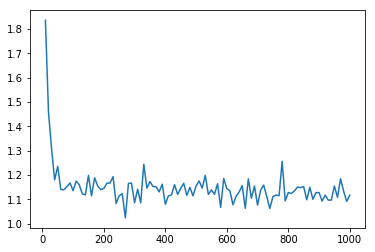

In [79]:
counter = []
loss_history = []
iteration_number = 0
        
for epoch in range(0, num_epochs):
    for i, data in enumerate(train_dataloader):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
                
        optimizer.zero_grad() # zero out the gradients as PyTorch accummulates gradients
        output1, output2 = net(img0, img1) 
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward() # run backprop
        optimizer.step() # update the weights
                
        if i%10 == 0:
            print("Epoch Number {} \n Current Loss {}\n".format(epoch, loss_contrastive.item()))
            iteration_number +=10 # this is just for the plot to make it look nicer
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

# Testing on hold out set

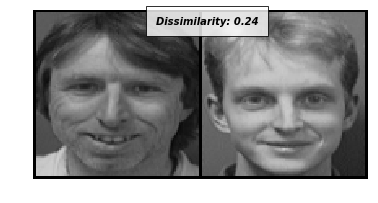

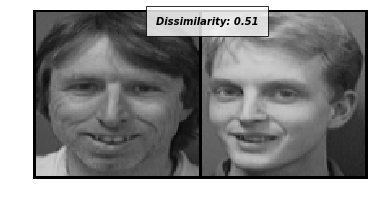

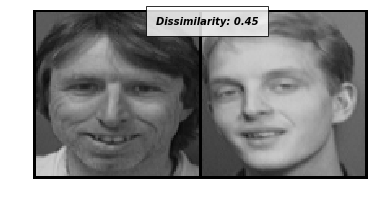

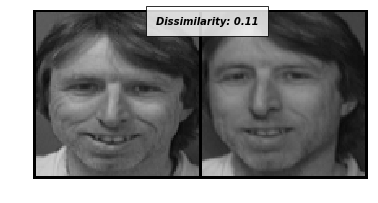

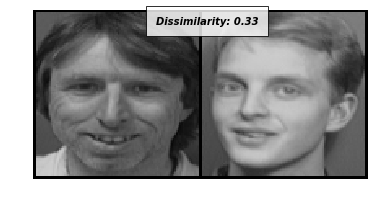

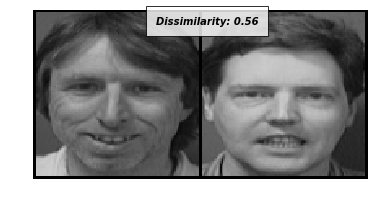

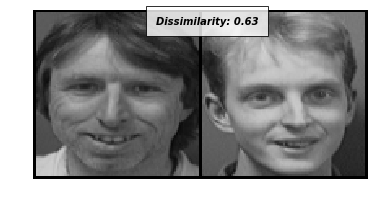

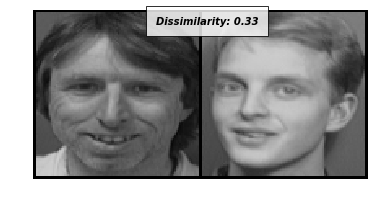

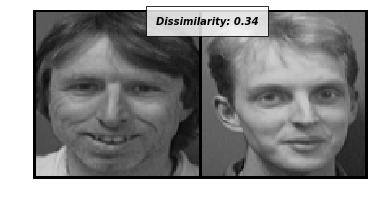

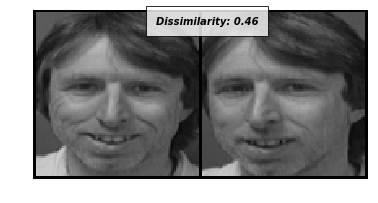

In [81]:
test_dataset = torchvision.datasets.ImageFolder(root=testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=test_dataset,
                                       transform = transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()]))
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,_ = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    output1, output2 = net(Variable(x0).cuda(), Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), 'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

# Real Test of Generalisability

In [15]:
realtest_dir = r'D:\Java1D\Java1DProject\orl_faces\realtest'

In [36]:
realtest_dataset = torchvision.datasets.ImageFolder(root=realtest_dir)
print(len(realtest_dataset))

8


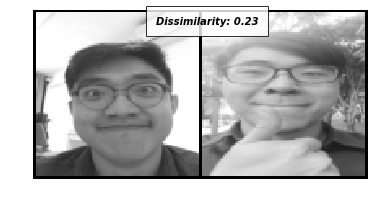

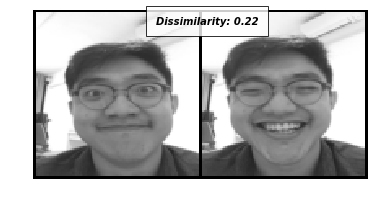

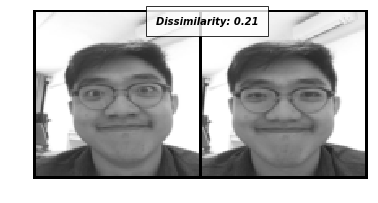

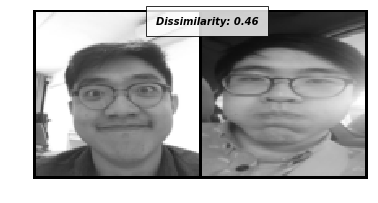

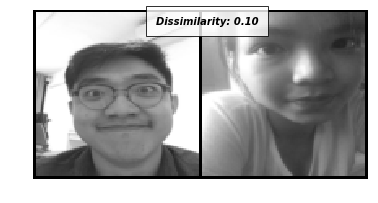

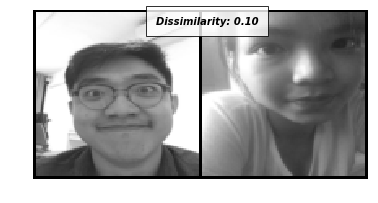

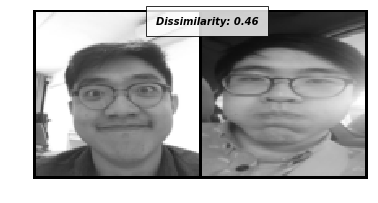

StopIteration: 

In [43]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=realtest_dataset,
                                       transform = transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()]))

realtest_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)
dataiter = iter(realtest_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,_ = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    output1, output2 = net(Variable(x0).cuda(), Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), 'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

Clearly, the results still leave a lot to be desired. In particular, images which are not upfront selfies are a huge problem. So in order for our accuracy to be higher, we definitely need to do some sort of preprocessing, face localization, etc. We could also try running over more epochs or adding more layers i.e. Batch Norm..